In [111]:
#Bibliotecas
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [61]:
plt.style.use('fivethirtyeight')

## Dados - Ibov

In [62]:
#Dados - IBOV

inicio = datetime.datetime(2019, 1, 1)
fim = datetime.datetime(2021, 12, 31)

ibov = yf.download('^BVSP', start=inicio, end=fim)[['Close', 'Adj Close']]
ibov.head()

[*********************100%***********************]  1 of 1 completed


,Close,Adj Close
Date,,
2019-01-02,91012.0,91012.0
2019-01-03,91564.0,91564.0
2019-01-04,91841.0,91841.0
2019-01-07,91699.0,91699.0
2019-01-08,92032.0,92032.0


In [63]:
#Retorno simples - Ibov

retorno_simples_ibov = np.log(ibov['Adj Close'] / ibov['Adj Close'].shift())
retorno_simples_ibov.head()

Date
2019-01-02         NaN
2019-01-03    0.006047
2019-01-04    0.003021
2019-01-07   -0.001547
2019-01-08    0.003625
Name: Adj Close, dtype: float64

In [65]:
#Retorno acumulado - Ibov

retorno_acumulado_ibov = (1 + retorno_simples_ibov).cumprod()
retorno_acumulado_ibov.fillna(1, inplace=True)
retorno_acumulado_ibov.head()

Date
2019-01-02    1.000000
2019-01-03    1.006047
2019-01-04    1.009086
2019-01-07    1.007524
2019-01-08    1.011176
Name: Adj Close, dtype: float64

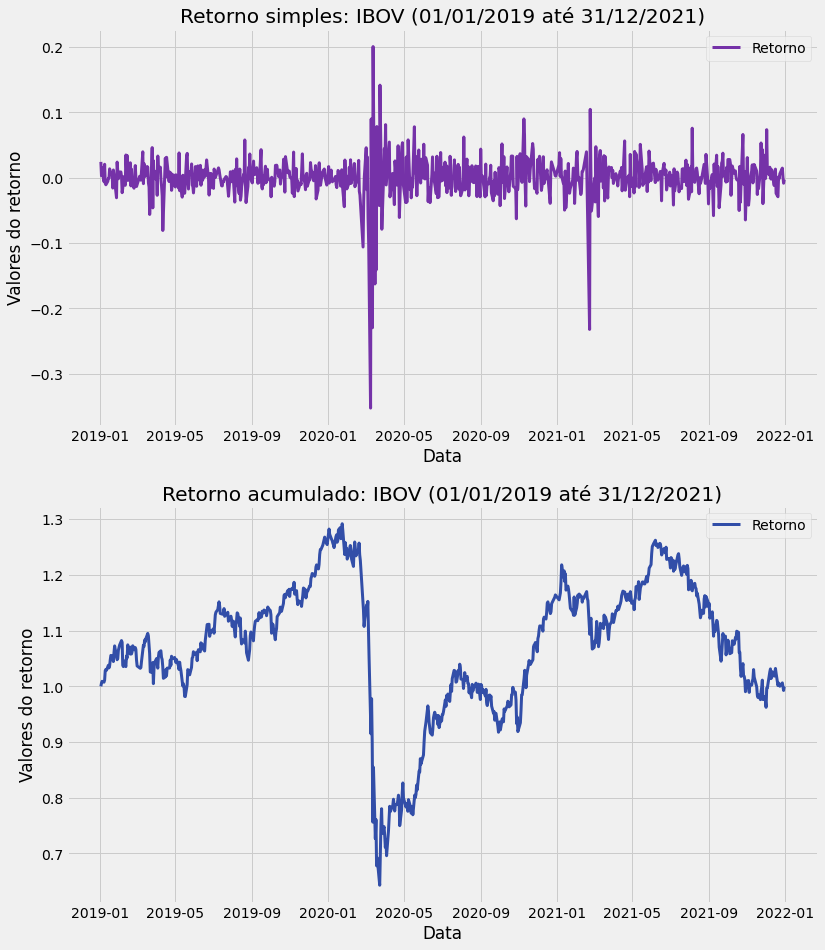

In [66]:
#Visualização

plt.figure(figsize=(12, 15));
plt.subplot(211);
plt.plot(retorno_simples, label='Retorno', color='#7532a8', linewidth=3);
plt.title('Retorno simples: IBOV (01/01/2019 até 31/12/2021)');
plt.ylabel('Valores do retorno');
plt.xlabel('Data');
plt.legend();

plt.subplot(212);
plt.plot(retorno_acumulado, label='Retorno', color='#324ea8', linewidth=3);
plt.title('Retorno acumulado: IBOV');
plt.ylabel('Valores do retorno');
plt.xlabel('Data');
plt.legend();

## Dados - ativo

In [67]:
#Dados - ativo

ativo = yf.download('PETR4.SA', start=inicio, end=fim)[['Close', 'Adj Close']]
ativo.head()

[*********************100%***********************]  1 of 1 completed


,Close,Adj Close
Date,,
2019-01-02,24.059999,18.925684
2019-01-03,24.650000,19.389782
2019-01-04,24.719999,19.444843
2019-01-07,25.110001,19.751619
2019-01-08,24.959999,19.633629


In [68]:
#Retorno simples - ativo

retorno_simples_ativo = np.log(ativo['Adj Close'] / ativo['Adj Close'].shift())
retorno_simples_ativo.head()

Date
2019-01-02         NaN
2019-01-03    0.024226
2019-01-04    0.002836
2019-01-07    0.015654
2019-01-08   -0.005992
Name: Adj Close, dtype: float64

In [69]:
#Retorno acumulado - ativo

retorno_acumulado_ativo = (1 + retorno_simples_ativo).cumprod()
retorno_acumulado_ativo.fillna(1, inplace=True)
retorno_acumulado_ativo.head()

Date
2019-01-02    1.000000
2019-01-03    1.024226
2019-01-04    1.027131
2019-01-07    1.043209
2019-01-08    1.036958
Name: Adj Close, dtype: float64

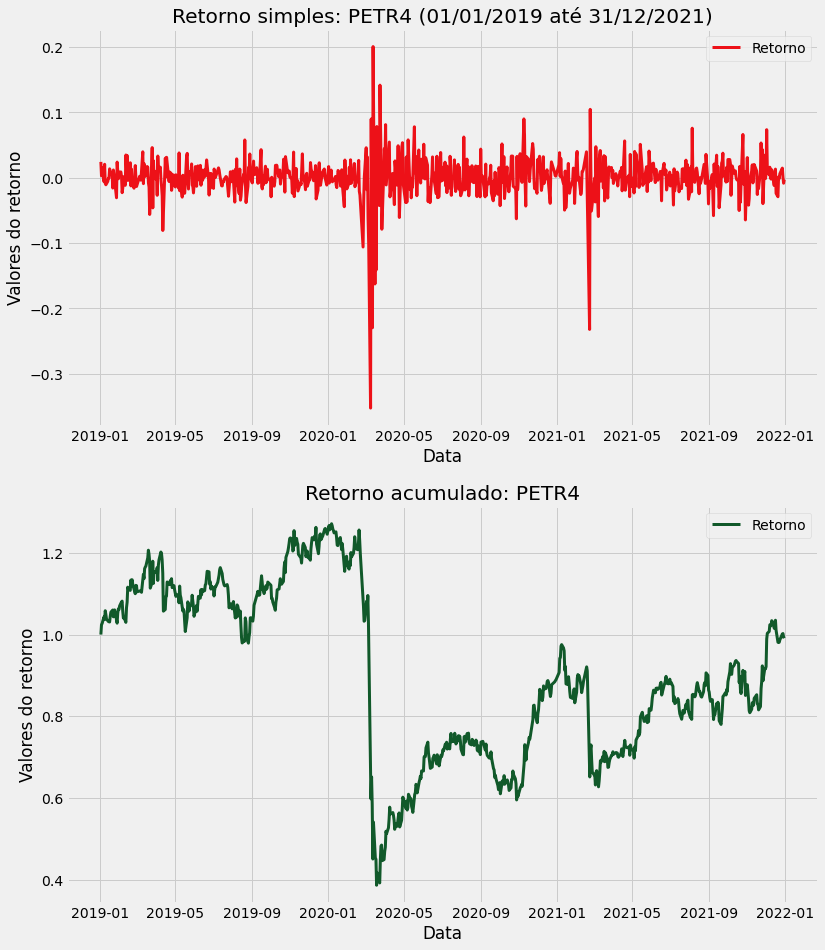

In [72]:
#Visualização

plt.figure(figsize=(12, 15));
plt.subplot(211);
plt.plot(retorno_simples_ativo, label='Retorno', color='#ed1118', linewidth=3);
plt.title('Retorno simples: PETR4 (01/01/2019 até 31/12/2021)');
plt.ylabel('Valores do retorno');
plt.xlabel('Data');
plt.legend();

plt.subplot(212);
plt.plot(retorno_acumulado_ativo, label='Retorno', color='#11592a', linewidth=3);
plt.title('Retorno acumulado: PETR4');
plt.ylabel('Valores do retorno');
plt.xlabel('Data');
plt.legend();

## Dados - Selic Meta

In [ ]:
url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.432/dados?formato=json'

selic_meta = pd.read_json(url)

#Adaptando a base de dados

selic_meta['data'] = pd.to_datetime(selic_meta['data'], dayfirst=True)
selic_meta.set_index('data', inplace=True)
selic_meta.head()

In [75]:
#Ativo livre de risco

rf = selic_meta.iloc[-1]
rf

valor    9.25
Name: 2022-02-02 00:00:00, dtype: float64

# DataFrame para o CAPM para o retorno acumulado

In [98]:
capm = pd.DataFrame()
capm['Rf'] = rf[0]
capm['Rm'] = retorno_acumulado_ibov
capm['Ri'] = retorno_acumulado_ativo
capm['Rm - Rf'] = retorno_acumulado_ibov - rf[0]

for i in capm['Rf']:
    capm['Rf'] = rf[0]
    
capm.head()

,Rf,Rm,Ri,Rm - Rf
Date,,,,
2019-01-02,9.25,1.000000,1.000000,-8.250000
2019-01-03,9.25,1.006047,1.024226,-8.243953
2019-01-04,9.25,1.009086,1.027131,-8.240914
2019-01-07,9.25,1.007524,1.043209,-8.242476
2019-01-08,9.25,1.011176,1.036958,-8.238824


## Estimando o modelo com Statsmodels

In [119]:
#Estimação do modelo

y = capm['Ri']
x = capm['Rm - Rf']
#const = capm['Rf']

X = sm.add_constant(x)
resultado = sm.OLS(y, X).fit()

In [120]:
resultado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Ri   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     440.1
Date:                Wed, 05 Jan 2022   Prob (F-statistic):           4.63e-77
Time:                        19:20:40   Log-Likelihood:                 285.66
No. Observations:                 743   AIC:                            -567.3
Df Residuals:                     741   BIC:                            -558.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.5369      0.411     23.180      0.000       8.729      10.345
Rm - Rf        1.0552      0.050     20.979      0.000       0.956       1.154
==============================================================================
Omnibus:                     1344.428   Durbin-Watson:                   0.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.139
Skew:                          -0.025   Prob(JB):                     4.77e-12
Kurtosis:                       1.703   Cond. No.                         564.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [121]:
#Parametros estimados

resultado.params

const      9.536869
Rm - Rf    1.055248
dtype: float64

## Estimando o modelo com Sklearn

In [128]:
#Redefinindo o formato da matriz

y = capm['Ri']
x = capm['Rm - Rf']

X = x.values.reshape(-1, 1)

In [129]:
#Estimação do modelo

reg = LinearRegression()
reg.fit(X, y)

LinearRegression()

In [131]:
#R-square

reg.score(X, y)

0.37262020026374354

In [132]:
#Intercepto

reg.intercept_

9.536868849727835

In [136]:
#Coeficiente

reg.coef_[0]

1.055247829726944

In [137]:
#Previsão do modelo

y_chapeu = reg.predict(X)

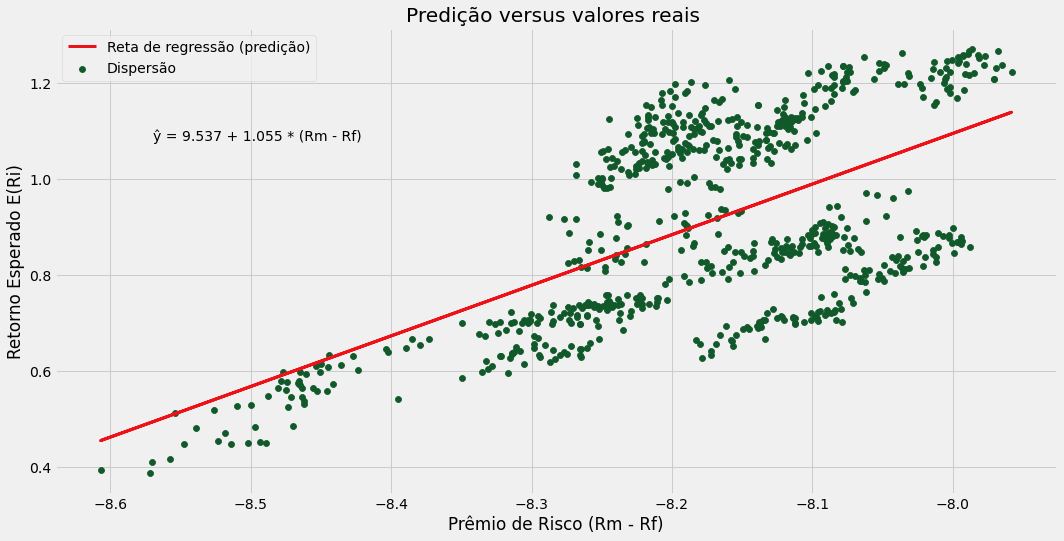

In [159]:
#Visualização

plt.figure(figsize=(16, 8));
plt.plot(x, y_chapeu, label='Reta de regressão (predição)', color='#ed1118', linewidth=3);
plt.scatter(x, y, label='Dispersão', color='#11592a', linewidth=0.8);
plt.title('Predição versus valores reais ');
plt.ylabel('Retorno Esperado E(Ri)');
plt.xlabel('Prêmio de Risco (Rm - Rf)');
plt.text(-8.57, 1.08, f'ŷ = {np.round(reg.intercept_, 3)} + {np.round(reg.coef_[0], 3)} * (Rm - Rf)');
plt.legend();

# DataFrame para o CAPM para o retorno simples